In [65]:
# Machine Learning Homework 3 -- Question 1
# Dominic Ridley

In [66]:
import scipy.io as spio
import matplotlib.pyplot as plt
import sys
import warnings
import math
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from math import log
import numpy as np
from numpy import isneginf
np.seterr(divide='ignore')
import scipy

In [67]:
dtrain_data = spio.loadmat('d_train.mat')['data']
dtrain_labels = spio.loadmat('d_train.mat')['labels']

dtest_data = spio.loadmat('d_test.mat')['data']
dtest_labels = spio.loadmat('d_test.mat')['labels']

dtrain500_data = spio.loadmat('d_train500.mat')['data']
dtrain500_labels = spio.loadmat('d_train500.mat')['labels']

dtrain1k_data = spio.loadmat('d_train1000.mat')['data']
dtrain1k_labels = spio.loadmat('d_train1000.mat')['labels']

In [68]:
nClasses = 3

class MLPerceptronModel:
    def __init__(self, data, labels, nPerceptrons):
        
        self.nPerceptrons = nPerceptrons
        
        #x1: Input Data
        self.data = data
        self.data_len = len(data)
        self.x1_size = len(self.data[0])
        #y: True Labels
        lb = MultiLabelBinarizer()
        self.labels = lb.fit_transform(labels)
        
        #Hidden Layer
        self.hl = {'weights': np.random.rand(self.x1_size, self.nPerceptrons) * np.sqrt(1.0/5),
              'biases': np.random.uniform(-3, 3, size=(self.nPerceptrons, )) }
        #{'weights': np.random.uniform(-3, 3, size=(self.x1_size, self.nPerceptrons))
        #self.hl = {'weights': np.random.randn(self.x1_size, self.nPerceptrons),
        #      'biases': np.random.randn(self.nPerceptrons, ) }
        self.ah = np.zeros((self.x1_size, nPerceptrons))
        
        #Output Layer
        self.ol = {'weights': np.random.rand(self.nPerceptrons, nClasses) * np.sqrt(1.0/5),
              'biases': np.random.uniform(-3, 3, size=(nClasses, )) }
            #{'weights': np.random.uniform(-3, 3, size=(self.nPerceptrons, nClasses))
        #self.ol = {'weights': np.random.randn(self.nPerceptrons, nClasses),
        #     'biases': np.random.randn(nClasses, ) }
        self.ao = np.zeros((self.x1_size, nClasses))
    
        #Softmax Layer
        self.sml = np.zeros((self.x1_size, nClasses))
        
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def d_sigmoid(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)
    
    def isru(self, x):
        e = np.array(x, copy=True)
        for j_idx, j in enumerate(e):
            for k_idx, k in enumerate(j):
                e[j_idx, k_idx] = k / (math.sqrt(1 + 0.2 * (math.pow(k, 2)) ) )  
        return e
    
    def d_isru(self, x):
        e = np.array(x, copy=True)
        for j_idx, j in enumerate(e):
            for k_idx, k in enumerate(j):
                e[j_idx, k_idx] = math.pow((1 / (math.sqrt(1 + 0.2 * (math.pow(k, 2)) ) )), 3)
        return e
    
    def elu(self, x):
        e = np.array(x, copy=True)
        for j_idx, j in enumerate(e):
            for k_idx, k in enumerate(j):
                if k > 0:
                    e[j_idx, k_idx] = k
                else:
                    e[j_idx, k_idx] = 0.2 * (math.exp(k) - 1)
        return e
    
    def d_elu(self, x):
        e = np.array(x, copy=True)
        for j_idx, j in enumerate(e):
            for k_idx, k in enumerate(j):
                if k > 0:
                    e[j_idx, k_idx] = 1
                else:
                    e[j_idx, k_idx] = 0.2 * (math.exp(k))
        return e
    
    def softmax(x):
        expo = np.exp(x)
        expo_sum = np.sum(np.exp(x))
        return expo/expo_sum

    def forwardprop_wElu(self):

        #data = np.array([self.data])
        l1 = np.add( np.dot(self.data, self.hl['weights']), self.hl['biases'] )
        self.ah = self.isru(l1)
        
        output = np.dot(self.ah, self.ol['weights']) + self.ol['biases'] 
        self.ao = np.float32(scipy.special.softmax(output, axis=1))
        #return output
    
    def forwardprop_wSigmoid(self):
        
        l1 = np.add( np.dot(self.data, self.hl['weights']), self.hl['biases'] )
        self.ah = self.sigmoid(l1)
        
        output = np.dot(self.ah, self.ol['weights']) + self.ol['biases'] 
        self.ao = np.float32(scipy.special.softmax(output, axis=1))

        #return output
    
    def softmax_cross_entropy_loss(self):
            y = self.labels
            y_hat = self.ao
            #sm_log = np.log(scipy.special.softmax(y_hat, axis=1))
            sml_log = np.log( y_hat )
            sml_log[isneginf(sml_log)]= -9999
            sml_log[sml_log == 0] == 10 * math.exp(-10)
            softmax_layer = -np.sum([np.dot(y[i], sml_log[i]) for i in range(len(y))])
            self.sml = softmax_layer
            
    def backProp(self, af, lr):
        
        '''
        Formulas:
        dcost_wo = (y_hat - y) * ah
        
        dcost_bo = (y_hat - y)
        
        dcost_wh = (y_hat - y) * wo * x1 * d_sigmoid
        
        dcost_bh = (y_hat - y) * wo * d_sigmoid
        '''
        hl = np.add( np.dot(self.data, self.hl['weights']), self.hl['biases'] )
        #print(hl)
        if af == 0:
            d_af = self.d_isru(hl)
        if af == 1:
            d_af = self.d_sigmoid(hl)
        
        #Compute Gradients
        #print(self.ao, self.labels)
        
        dC_wh_g = np.float64(np.zeros((2, self.nPerceptrons)))
        dC_bh_g = np.zeros((self.nPerceptrons, 1))
        dC_wo_g = np.zeros((self.nPerceptrons, 3))
        dC_bo_g = np.zeros((3, ))
        
        for i, x in enumerate(self.data):
            dC_ao = np.subtract(self.ao[i], self.labels[i]) #/ self.data_len

            dC_wo_g += np.dot(np.array([dC_ao]).T, np.array([self.ah[i]])).T

            dC_bo_g += dC_ao
            #dC_bo = np.mean(dC_bo, axis=0).T

            dC_wh = np.array([np.dot(dC_ao, self.ol['weights'].T)])
            #print(dC_wh)
            dC_wh = np.dot(dC_wh.T, np.array([self.data[i]]))
    
            dC_wh = np.dot(dC_wh.T, np.array([d_af[i]]).T)
            dC_wh_g += dC_wh
            #dC_wh = np.array([np.mean(dC_wh.T, axis=0)]).T

            dC_bh = np.array([np.dot(dC_ao, self.ol['weights'].T)])
            dC_bh = np.sum(dC_bh) * np.array([d_af[i]]).T
            #print(dC_bh)
            dC_bh_g += dC_bh
            
        #Update Weights
        self.hl['weights'] = self.hl['weights'] - (lr * dC_wh_g)
        self.hl['biases'] = self.hl['biases'] - (lr * dC_bh_g.T)
        self.ol['weights'] = self.ol['weights'] - (lr * dC_wo_g)
        self.ol['biases'] = self.ol['biases'] - (lr * dC_bo_g)

    def fit_model(self, test_data, test_labels, af, nPerceptrons):
        
        self.data = test_data
        
        if nPerceptrons == None:
            pass
        else:
            self.nPerceptrons = nPerceptrons
            
        if af == 0:
            self.forwardprop_wElu()
        if af == 1:
            self.forwardprop_wSigmoid()
        
        #print(self.ao.shape)
        predicted_labels = np.argmax(self.ao, axis=1)
        u = np.ones_like(predicted_labels)
        predicted_labels += u
        predicted_labels = np.array([predicted_labels]).T
        #plt.figure()
        
        
        #for i, xy in enumerate(test_data):
        #    if predicted_labels[i] == 1:
        #        plt.plot(xy[0], xy[1],'b.')
        #    if predicted_labels[i] == 2:
        #        plt.plot(xy[0], xy[1],'r.')
        #    if predicted_labels[i] == 3:
        #        plt.plot(xy[0], xy[1],'g.')
                
        #plt.show()
        #print(len(test_labels), len(predicted_labels))
        return accuracy_score(test_labels, predicted_labels), predicted_labels
    

In [69]:
def tenFoldCrossVal(data, labels):
    
    #Attach labels to data
    dtrain = np.concatenate((data.T, labels.T), axis=1)
    x_size = len(dtrain)
    
    #Shuffle the data
    np.random.shuffle(dtrain)
    
    #Split the data in 10 batches
    sizeBatches = 10
    batches = np.split(dtrain, sizeBatches)
    
    cost_matrix = np.zeros((6,2))
    #accuracy_matrix = np.zeros((6,2))
    full_a_matrix = []
    for test_idx, test_batch in enumerate( batches ):

        #training_set = batches[test_idx]
        #test_set = np.delete(batches, test_idx, 0)

        test_set = batches[test_idx]
        training_set = np.delete(batches, test_idx, 0)
        training_set = np.concatenate(training_set)
        train_data = training_set[:, :2]
        
        train_labels = training_set[:, 2:]

        test_data =  test_set[:, :2]
        test_labels = test_set[:, 2:]
        accuracy_matrix = np.zeros((6,2))
        
        
        
        for numPerceptrons in range(1,7):
            for af in range(2):
                t_cost = 0
                mscaler = MinMaxScaler()
                train_data = mscaler.fit_transform(train_data)
                test_data = mscaler.fit_transform(test_data)
                m = MLPerceptronModel(train_data, train_labels, numPerceptrons)
                learning_rate = 0.0001
                hm_epochs = 50
                print(numPerceptrons, af)
                for epoch in range(hm_epochs):
                    np.random.shuffle(train_data)
                    if af == 0:
                         m.forwardprop_wElu()
                    if af == 1:
                         m.forwardprop_wSigmoid()
                    m.backProp(af, learning_rate)
                    m.softmax_cross_entropy_loss()
                    t_cost += m.sml
                    print(m.sml)
                #print("NEW")
                #cost_matrix[numPerceptrons-1, af] = t_cost
                #Fit Model
                a = m.fit_model(test_data, test_labels, af, None)
                accuracy_matrix[numPerceptrons-1, af] = a[0]
                
                learning_rate = math.exp(-epoch)
                
        full_a_matrix.append(accuracy_matrix)
        #print('Epoch', epoch, 'numPerceptrons', numPerceptrons, 'af', af, 'Cost:', \
        #          t_cost)
    full_a_matrix = np.array(full_a_matrix)
    full_a_matrix = np.mean(full_a_matrix, axis = 0)

    print(full_a_matrix)
    e_pair = np.unravel_index(np.argmax(full_a_matrix, axis=None), \
                                    full_a_matrix.shape)
    
    e_pair = tuple([e_pair[0] + 1, e_pair[1]])
    print(e_pair)
    return m, e_pair

n_error = True
while(n_error):
    try:
        n, e_pair = tenFoldCrossVal(dtrain_data, dtrain_labels)
        nPerceptrons = e_pair[0]
        af = e_pair[1]
        test_score, test_labels = n.fit_model(dtest_data.T, dtest_labels.T, af, nPerceptrons)
        print(test_score)
        plt.figure()
        
        test_labels = test_labels.T
        for i, xy in enumerate(dtest_data.T):
            if test_labels[i] == 1:
                plt.plot(xy[0], xy[1],'b.')
            if test_labels[i] == 2:
                plt.plot(xy[0], xy[1],'r.')
            if test_labels[i] == 3:
                plt.plot(xy[0], xy[1],'g.')
                
        plt.show()
        
        n_error = False
    #except ValueError as ve:
    #    print(ve)
    #    print('\nReinitializing')
    except ZeroDivisionError:
        print('Reinitializing')
    except RuntimeError:
        print('Reinitializing')


1 0
846.4446157068014
825.6623095870018
806.0861669182777
787.7011995315552
770.477998226881
754.1030823588371
738.8643985688686
724.5689873099327
711.1545339226723
698.448787599802
686.4622547328472
675.1015455722809
664.5445091128349
654.567471832037
644.9260447025299
636.1340734362602
627.6716747879982
619.6546849012375
611.6785690188408
604.6401724219322
597.6556463837624
591.1596174240112
585.0836520195007
578.8072538375854
573.606932759285
567.9215964078903
563.099444270134
558.4948151111603
553.9788275361061
549.8077570199966
545.3659275174141
541.7291302680969
538.5234687328339
535.0247998833656
531.8521392345428
528.7460339069366
525.6855063438416
523.5454444289207
520.9740016460419
519.1496986746788
517.1124046444893
515.0030599832535
513.1132330298424
511.37625855207443
510.1965080499649
508.9555035829544
507.02668809890747
506.3341607451439
505.09138029813766
503.8151706457138
1 1
531.4645384550095
529.8017949461937
528.2398297190666
526.7256942987442
525.2427228689194
523.

805.5445885360241
789.5546498894691
774.8181502819061
760.623814702034
747.2626505196095
734.7029068768024
722.3646754920483
711.2483386397362
700.3055802881718
690.0029382109642
679.2798560857773
670.1015635728836
660.6348058581352
651.6432124972343
643.1624562740326
635.3517558574677
627.59536921978
620.3574483990669
612.625319480896
605.8616905212402
599.1686962246895
592.5771726965904
587.0111930370331
581.1039155721664
575.3878499865532
570.3084341883659
565.1663883328438
560.3807938694954
555.2445094585419
550.8719113469124
546.4208390712738
543.4868791103363
539.0116305947304
535.4480817317963
532.7713580727577
529.6045987606049
526.4991969466209
523.4660279750824
520.8499213457108
519.0443951487541
517.0572136044502
515.3380380868912
513.2244522571564
6 0
845.5987676978111
789.2184737324715
742.7275097668171
703.9027145504951
670.2341510653496
640.7037572264671
614.8296253681183
591.8903822898865
572.26339584589
555.7425872683525
541.8721260428429
530.4899069070816
521.46659827

494.5994266271591
494.31781136989594
494.25305247306824
493.9482845067978
494.0094783306122
493.8265116214752
493.84080743789673
493.83995163440704
493.83329260349274
493.87689673900604
493.8110305070877
493.76240289211273
493.8440784215927
493.7305953502655
493.7618975639343
493.7426517009735
493.73606872558594
493.734158039093
493.7851415872574
493.7470061779022
493.8301272392273
493.7808223962784
493.79014801979065
493.78828942775726
493.7358777523041
493.7859033346176
493.87326216697693
493.8404779434204
493.779704451561
493.7662875652313
493.8450013399124
493.88475501537323
493.7543662786484
4 1
690.1703209578991
678.5442839562893
667.6119694709778
657.2930134832859
647.5947546064854
638.4185388684273
629.7982195615768
621.7140618860722
614.047675460577
606.8495756387711
600.1076837778091
593.6534615755081
587.6423453092575
581.972949385643
576.5753527283669
571.475592136383
566.7610294222832
562.1670722961426
557.9920826554298
553.9396255016327
550.2072040438652
546.6473944187164

678.5606998205185
667.0068238377571
656.1927790641785
645.9870694279671
636.3259769380093
627.3071786463261
618.8093228936195
610.8149737417698
603.3774465024471
596.3062056601048
589.7679656147957
583.6313158273697
577.8340524435043
572.3961352705956
567.3531742691994
562.581300497055
558.2692739367485
554.064092874527
550.1890493631363
546.5263806581497
543.0605363845825
539.957258939743
536.934906244278
534.167248904705
531.5635112524033
529.1191053390503
526.6765934228897
524.681864798069
3 0
844.310871720314
828.0337736606598
812.6781208515167
797.4579094052315
782.3390833735466
767.8858463168144
753.3938111066818
739.729231774807
725.9726414680481
712.5186032652855
699.8702968358994
686.9784532189369
675.0884548425674
663.3508279323578
651.793937921524
640.7157340049744
630.4687814712524
620.6711992621422
610.741085767746
601.3965519666672
592.8127061128616
584.6576188206673
577.1682901382446
569.7985634207726
562.6898840665817
556.2661134600639
550.5314603447914
545.097905457019

547.5097900032997
543.13853931427
539.0735439062119
535.1466503739357
531.7580815553665
528.2565596103668
525.1803557872772
522.2455487251282
519.9074456095695
517.3696442842484
515.2545677423477
513.2233080267906
511.40138334035873
509.5536395907402
507.98112404346466
506.8236978650093
505.54136526584625
504.2668939232826
503.0204358100891
502.3271544575691
501.57843309640884
500.63637602329254
1 1
932.984886109829
924.0882773399353
915.376379519701
906.889907091856
898.6794060766697
890.6541874706745
882.8479105234146
875.1743252575397
867.7149767279625
860.4002706408501
853.2428239881992
846.3075422048569
839.521233022213
832.8460429012775
826.3719137012959
820.0031531453133
813.7822290360928
807.6928318142891
801.7295002639294
795.8892857730389
790.1714281141758
784.5593076050282
779.0379805862904
773.6231387853622
768.3392139673233
763.1344220638275
758.0447514653206
752.9649823904037
748.0567709505558
743.169278293848
738.3171153068542
733.6914937496185
729.0786965489388
724.4061

511.6644621491432
510.1338849067688
508.74711096286774
507.69841027259827
506.44555884599686
505.42661142349243
504.4377426505089
503.5883714556694
502.73121523857117
502.09110605716705
501.43851321935654
500.92815840244293
500.1820579767227
499.6539960503578
499.2428869009018
498.7564609646797
498.3400789499283
6 0
1025.885888800025
884.8602776527405
771.4629520773888
687.2925384640694
628.2000146508217
587.4835096001625
558.9443390369415
539.0675290822983
524.7499665021896
515.3714305758476
508.1438403725624
503.70393788814545
500.1117984652519
498.0457674264908
496.77700912952423
495.8201049566269
495.68936014175415
495.1899234056473
494.4891508817673
494.19280183315277
494.59871423244476
494.47744584083557
494.269083738327
494.1211552619934
494.63124227523804
494.1327475309372
494.7027121782303
494.56022000312805
494.48723244667053
494.73987674713135
494.1280509233475
494.27129328250885
494.2046583890915
494.16896295547485
494.00245332717896
494.2787951231003
494.5595339536667
494.

494.6633982658386
494.24252820014954
494.2995364665985
494.0977442264557
494.36912775039673
494.12644946575165
494.1121530532837
494.1011782884598
494.2867442369461
493.9703928232193
494.4019273519516
493.86150312423706
494.36881709098816
494.39648735523224
4 1
691.6039970517159
684.8828490972519
678.4008575081825
672.064900457859
666.0115439295769
659.982279241085
654.2308983206749
648.5911748409271
643.0929907560349
637.8057548999786
632.6234449744225
627.5883241295815
622.7053242921829
617.9457596540451
613.3573862910271
608.8609090447426
604.4835028648376
600.2750667333603
596.1298872828484
592.1561577916145
588.2548123598099
584.4921329021454
580.8639727830887
577.2817870974541
573.9160593152046
570.5916996002197
567.3868308067322
564.1920317411423
561.2279181480408
558.3121295571327
555.5499053001404
552.8017238378525
550.1795132756233
547.7269006371498
545.2140045166016
542.9176974892616
540.6205197572708
538.5083717107773
536.412572145462
534.4020349383354
532.4709448218346
530

570.7677901387215
568.1716458201408
565.5997425317764
563.1384521722794
560.7073710560799
558.3646055459976
556.0623393654823
553.8362980484962
551.6591572165489
549.5427556633949
547.5051733255386
3 0
809.1068820357323
776.0141090750694
746.4710779190063
720.1724880933762
696.6982449889183
675.8657067716122
657.173677355051
640.4800468087196
625.4012842178345
611.8084655404091
599.4466479420662
588.3254510164261
578.1662391424179
568.9216683506966
560.6953949332237
553.096005320549
546.203216612339
540.1113508939743
534.5649387836456
529.4804094433784
525.0011659264565
521.1417870521545
517.5982172489166
514.6058264970779
511.784207880497
509.38969081640244
507.27909660339355
505.4759364724159
503.783507168293
502.5467349886894
501.12451338768005
500.2030667066574
499.3126491904259
498.618567943573
497.87247854471207
497.34778594970703
496.81718146800995
496.55987364053726
496.07899475097656
495.8993774652481
495.52058005332947
495.2750414609909
495.05096554756165
495.078396320343
494

495.9682457447052
495.6077649593353
495.49654710292816
495.20741379261017
495.08794260025024
495.0460730791092
494.789434671402
494.7454560995102
494.6248996257782
1 1
510.09249371290207
509.11853885650635
508.22480499744415
507.37546050548553
506.57669258117676
505.81869661808014
505.1121287345886
504.4370966553688
503.8319621682167
503.24938893318176
502.68117409944534
502.1488795876503
501.6867243051529
501.2042698264122
500.7782975435257
500.3663306236267
499.9840017557144
499.6136786341667
499.2711092233658
498.94783133268356
498.64886659383774
498.3715644478798
498.1083689928055
497.8472378253937
497.62515729665756
497.3996586203575
497.19659662246704
497.00830376148224
496.801108956337
496.6305774450302
496.4590513706207
496.3205028772354
496.161433160305
496.0240759253502
495.89875864982605
495.75773668289185
495.66642183065414
495.5510923862457
495.44518637657166
495.3594491481781
495.2866758108139
495.1927295923233
495.10768151283264
495.02194809913635
494.9496043920517
494.9

494.9560585618019
494.9036998152733
494.4405145049095
494.3158640861511
494.4339013695717
494.4385005235672
494.2007630467415
6 0
879.3933049440384
842.6664043068886
809.5073422789574
779.9529730081558
752.5682727694511
726.4356160163879
701.1306937336922
679.4519262313843
656.5571883916855
636.4016934633255
616.8335813879967
598.9761484861374
582.1165633201599
568.1456953883171
554.8884545564651
543.2245346903801
533.6044372916222
524.0657204389572
518.0402758717537
512.5977236032486
507.71363174915314
504.1169872879982
502.13519644737244
499.72830933332443
498.129585146904
497.1737063527107
496.0313985347748
494.83441013097763
494.93033450841904
494.23227417469025
494.64948588609695
495.0902844071388
495.46370553970337
493.7805327177048
493.63161194324493
493.0046970844269
494.21540105342865
494.8271585702896
493.7867442369461
493.70870101451874
494.0779755115509
492.42204797267914
492.7511321902275
495.0058410167694
494.1254233121872
494.0669411420822
493.035768032074
494.8504884243

513.7748975753784
512.3424727320671
511.0189301967621
509.81061351299286
508.69464188814163
507.6615795493126
506.6986156105995
505.76016664505005
504.9183351993561
504.20447450876236
503.5123557448387
502.8262119293213
502.2133894562721
501.61853045225143
501.0584280490875
500.50765401124954
500.1311627626419
499.68716126680374
499.32723569869995
498.87917417287827
498.5947476029396
498.30775398015976
498.00039303302765
497.78091728687286
497.462107360363
497.1425375342369
496.90171253681183
496.77471417188644
496.622998714447
496.40008318424225
496.23235535621643
496.0135782957077
495.9172560572624
495.7645462155342
495.71388244628906
495.56852316856384
495.52816301584244
495.33014196157455
495.2816236615181
495.0928922891617
495.1478328704834
494.9887244105339
494.97667640447617
494.839832007885
494.8902774453163
494.72418999671936
494.707985162735
494.68604242801666
494.63049590587616
494.63853108882904
5 0
624.2669342756271
604.2694774270058
586.9517253041267
571.6290066242218
558

664.0778869390488
635.1582523584366
610.4787760078907
589.5963578820229
572.5364861786366
558.287589609623
546.3926216959953
536.7422803044319
529.1311168670654
522.8576731681824
517.3879588842392
512.8749937415123
510.02092415094376
506.8307256102562
504.5354431271553
502.96025544404984
501.08425748348236
499.8828436136246
498.82211297750473
497.95098799467087
497.22382938861847
497.1813051700592
496.3971990942955
495.94832891225815
495.5442599058151
495.20912504196167
495.25300896167755
495.439391374588
494.5576946735382
494.5021495819092
494.4381470680237
494.7197892665863
494.29690766334534
494.36195170879364
494.37199890613556
494.30737471580505
494.41768777370453
494.419531583786
494.46238899230957
494.26611626148224
494.32063460350037
493.8904001712799
494.49054622650146
493.95064997673035
494.4298063516617
3 1
983.4008528888226
968.9958395063877
955.0789856314659
941.7215085029602
928.8272544145584
916.4015719592571
904.433366715908
892.784260481596
881.5356183052063
870.790028

543.1722041964531
541.4526022672653
539.7892335057259
538.1534723639488
536.585341334343
535.0472249984741
533.5613666772842
532.112841129303
530.70542126894
529.317596912384
528.0289857983589
526.7296249270439
525.5415543317795
524.3041828274727
523.1781358718872
522.0455686450005
520.9451754689217
519.8659085035324
518.8945590257645
517.9255474209785
516.968557536602
516.0218713879585
515.1168817281723
514.299593269825
513.4470342993736
512.6477809548378
511.9050523638725
511.1699889302254
510.4895324707031
509.7909828424454
509.18068450689316
508.5005831718445
507.90635883808136
507.31495237350464
506.7198688387871
506.1739674806595
505.653781414032
505.1393389701843
2 0
1037.6495783030987
999.6728426814079
965.5088283419609
934.7933387756348
906.7943489849567
880.8063408732414
857.1977133154869
834.8145081400871
813.8020350337029
794.185578763485
774.6351799368858
756.4239326119423
738.6239168047905
721.5551788806915
704.6288145184517
688.1305441260338
673.2591673731804
657.8863785

500.57904040813446
498.6453278064728
497.18270909786224
496.31249392032623
495.2950140237808
494.9398281574249
494.6482552289963
494.4725344181061
494.1537481546402
493.9527088403702
494.679163813591
494.27696204185486
493.83923530578613
493.9042304754257
493.76701843738556
493.7342361211777
494.0064500570297
493.81675708293915
493.62860733270645
494.2642548084259
494.1420570611954
493.96979081630707
493.60581773519516
493.96944707632065
494.2519884109497
494.11755418777466
493.9357624053955
493.26925390958786
493.7664950489998
493.85077142715454
493.7834524512291
6 1
701.2912969589233
690.72117587924
680.6309733688831
671.1102610528469
662.2791549563408
653.6572508811951
645.5668820142746
637.880858361721
630.3268795013428
623.1471282839775
616.5203019976616
610.2359097003937
603.9480684995651
598.047322511673
592.4387893080711
586.9445580840111
581.7438760995865
576.6811816096306
572.079250395298
567.4338706731796
563.1512768864632
559.0159823298454
555.220783829689
551.1266297101974

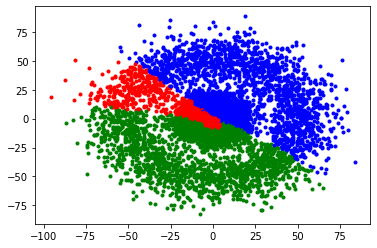

In [70]:
n_error = True
while(n_error):
    try:
        n, e_pair = tenFoldCrossVal(dtrain500_data, dtrain500_labels)
        nPerceptrons = e_pair[0]
        af = e_pair[1]
        test_score, test_labels = n.fit_model(dtest_data.T, dtest_labels.T, af, nPerceptrons)
        print(test_score)
        plt.figure()
        
        test_labels = test_labels
        print(test_labels)
        for i, xy in enumerate(dtest_data.T):
            if test_labels[i] == 1:
                plt.plot(xy[0], xy[1],'b.')
            if test_labels[i] == 2:
                plt.plot(xy[0], xy[1],'r.')
            if test_labels[i] == 3:
                plt.plot(xy[0], xy[1],'g.')
                
        plt.show()
        
        n_error = False
    #except ValueError as ve:
    #    print(ve)
    #    print('\nReinitializing')
    except ZeroDivisionError:
        print('Reinitializing')
    except RuntimeError:
        print('Reinitializing')